These are TODO's from the EDA section to be implemented in the present notebook.
- FEATURE: replace zipcodes with respective mean longitude and latitude
- FEATURE: replace states with respective mean longitude and latitude
- FEATURE: area of each area could be added, along with density of panels for the given zip code 
- FEATURE: approximation of zipcode by first 2 digits 
- FEATURE: add aditional feature to mark US and non-US states
- FEATURE: merge Puerto Rico states into 1 state


- NULLS: drop nulls 

- SCALING: scaling num of panels group of features is required. Simply dividing by a constant to bring the mean of distribution closer to other features or normalising by mean could be attempted

# Table of Contents
- **[Data initiation](#1)** 
- **[Feature extraction](#2)** 
- **[Nulls](#3)**
- **[Scaling](#4)** 
- **[Saving output](#5)**

In [47]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

<a name='1'></a>
# Data initiation

In [48]:
init_df = pd.read_csv('datasets/geo_solar_panels.csv')                                              # reading initial df
state_accronyms = pd.read_csv('datasets/states_accro_mapping.csv', sep=';')                         # reading df with states accronyms
ref_df =  pd.read_csv('datasets/zip_code_database.csv')[['zip', 'state', 'latitude', 'longitude']]  # reading reference df sourced from www.unitedstateszipcodes.org
ref_df = ref_df.merge(state_accronyms, how='left', left_on='state', right_on='Accro') \
    [['zip', 'latitude', 'longitude', 'State']].rename(columns={'State': 'state'})                  # replacing accronyms with full state named in reference df

US_STATES = list(ref_df['state'].dropna().unique())

In [49]:
# constants

# coordinates of edge points of the Baja California State, 
# scraped from google maps because data for it is not available in the reference dataset
V_MAX = (32.6075076203434, -116.17031418367016)
V_MIN = (28.003118432017647, -113.53742601660399)
H_MIN = (32.00112326006394, -116.86791151884898)
H_MAX = (32.55026231739979, -114.82663290447606)

# fraction of state size to be used as aproximate state radius
RAD_FRACTION = .75

<a name='2'></a>
# Feature extraction

In [50]:
class FeatureExtractor:
    """
    Class to extract additional features. 
    Each method except private outputs one ore several columns to be merged to the initial df by index or other columns.
    """
    def __init__(self, long_min: pd.Series, long_max: pd.Series, lat_min: pd.Series, lat_max: pd.Series,
                 num_of_panels: pd.Series, usa_states: list[str], states_to_check: pd.Series, init_zips: pd.Series,
                 ref_df: pd.DataFrame, init_df_zip_col: str, init_df_state_col: str,
                 ref_df_zip_col: str, ref_df_lat_col: str, ref_df_long_col: str, ref_df_state_col: str, rad_fraction: float = RAD_FRACTION
                 ):
        
        self.long_min = long_min
        self.long_max = long_max
        self.lat_min = lat_min
        self.lat_max = lat_max

        self.num_of_panels = num_of_panels
        self.usa_states = usa_states
        self.states_to_check = states_to_check
        self.init_zips = init_zips
        
        self.init_df_zip_col = init_df_zip_col
        self.init_df_state_col = init_df_state_col

        self.ref_df = ref_df
        self.ref_df_zip_col = ref_df_zip_col
        self.ref_df_lat_col = ref_df_lat_col
        self.ref_df_long_col = ref_df_long_col
        self.ref_df_state_col = ref_df_state_col

        self.rad_fraction = rad_fraction

    def calc_mean_coords(self) -> tuple[pd.Series, pd.Series]:
        """Function calculates mean coordinates for a zip code"""
        lat_mean = (self.lat_max + self.lat_min) / 2
        long_mean = (self.long_max + self.long_min) / 2
        return lat_mean, long_mean

    def calc_zip_area(self) -> pd.Series:
        """The function calculates approx. area of zip code using min/max longitude and lattitude"""
        # adding small number to avoid zero area
        return abs(self.long_max - self.long_min) * abs(self.lat_max - self.lat_min) + .1
    
    def panels_density(self, zip_area: pd.Series) -> pd.Series:
        """Function calculates panels density in a zip_code based on zip_code area and number of panels for the zip_code"""
        return self.num_of_panels / zip_area
    
    def approx_zips(self) -> pd.Series:
        """Function returns a column with first 2 digits of zipcode given a columns of zipcodes"""
        return self.init_zips.astype('str').apply(lambda x: int(x[:2]))
    
    def mask_usa_states(self) -> pd.Series:
        """Function checks if states in the passed column are USA states"""
        return (self.states_to_check.isin(self.usa_states)).astype(int)
    
    def merge_pr_states(self) -> pd.Series:
        """Function replaces smaller Puerto Rico states with a single larger state"""
        local_states = self.states_to_check.copy()
        local_states.loc[(~local_states.isin(self.usa_states)) & (local_states!='Baja California')] = 'Puerto Rico'
        return local_states

    def zips_replacement(self, lat_long_zip_df: pd.DataFrame, 
                         init_df_mean_lat_col: str, init_df_mean_long_col: str) -> tuple[pd.Series, pd.Series]:
        """
        Function merged reference df to the provided df with lat and long and returns mean lat and long with the same index. 
        For zips with no records in the reference df, values are filled with mean coordinates from the original df.
        """
        local_df = lat_long_zip_df.merge(ref_df, how='left', left_on=self.init_df_zip_col, right_on=self.ref_df_zip_col)
        zip_lat = local_df[self.ref_df_lat_col].fillna(value=local_df[init_df_mean_lat_col])
        zip_long = local_df[self.ref_df_long_col].fillna(value=local_df[init_df_mean_long_col])
        return zip_lat, zip_long

    def __find_state_dim_centr(self, grouped_df: pd.DataFrame) -> pd.Series:
        """
        Private function that is used to calculate approximate radius and coordinates of centroids of state in the passed dataset.
        Input dataset should contain data for one state only.
        Output is pd.Series for the function to be used within pd.apply clause.
        """

        if (grouped_df.empty) | (grouped_df.shape[0] < 2): return pd.Series({'state_size': 0, 'centr_lat': 0, 'centr_long': 0})
        edge_points = grouped_df.loc[                                                               # sampling points along 4 edges of a state (N, S, E, W)
            (grouped_df[self.ref_df_lat_col]==max(grouped_df[self.ref_df_lat_col])) | 
            (grouped_df[self.ref_df_lat_col]==min(grouped_df[self.ref_df_lat_col])) |
            (grouped_df[self.ref_df_long_col]==max(grouped_df[self.ref_df_long_col])) | 
            (grouped_df[self.ref_df_long_col]==min(grouped_df[self.ref_df_long_col])) , :
        ][[self.ref_df_lat_col, self.ref_df_long_col]]
        if (edge_points.empty) | (edge_points.shape[0]<2): return pd.Series({'state_size': 0, 'centr_lat': 0, 'centr_long': 0})
        state_size = 0                                                                              # state_size is max Euclidian distance between sampled points
        for dimension in [self.ref_df_lat_col, self.ref_df_long_col]:
            dim_points = edge_points.loc[(edge_points[dimension]==max(edge_points[dimension])) |    # arranging data from sampled rows into 2 2d vectors
                                        (edge_points[dimension]==min(edge_points[dimension])), :].drop_duplicates(dimension).values
            state_size = max([state_size, np.linalg.norm(dim_points[0] - dim_points[1])])                # calculating max Euclidian distance between 2 2d vectors
        return pd.Series({'state_size': self.rad_fraction * state_size,                                     # approximate radius
                          'state_lat': grouped_df[self.ref_df_lat_col].sum() / grouped_df.shape[0],         # centroid latitude
                          'state_long': grouped_df[self.ref_df_long_col].sum() / grouped_df.shape[0]})      # centroid longitude
    
    def calc_centr_size(self) -> pd.DataFrame:
        """
        Function applies find_state_dim_centr function to the reference df and returns dataset with 3 columns: 
        state_size, mean state latitude, mean state longitude.
        """
        return self.ref_df[[self.ref_df_state_col, self.ref_df_lat_col, self.ref_df_long_col]][(self.ref_df[self.ref_df_lat_col]!=0)] \
                                    .dropna() \
                                    .groupby(self.ref_df_state_col) \
                                    .apply(self.__find_state_dim_centr)
    
    def clac_baja_ca_centr_size(self, v_max: tuple[float, float], v_min: tuple[float, float], 
                                      h_min: tuple[float, float], h_max: tuple[float, float]):
        """Function calculates centroid and size for Baja California state specifically"""
        vert_points = np.array([v_max, v_min])
        horiz_points = np.array([h_max, h_min])
        state_size = max([np.linalg.norm(vert_points[0] - vert_points[1]), 
                          np.linalg.norm(horiz_points[0] - horiz_points[1])])

        return {'state_size': state_size,
                'state_lat': (v_max[0] + v_min[0]) / 2,
                'state_long': (h_min[1] + h_max[1]) / 2}

In [51]:
extr = FeatureExtractor(
    long_min=init_df['long_min'],
    long_max=init_df['long_max'],
    lat_min=init_df['lat_min'],
    lat_max=init_df['lat_max'],
    init_zips=init_df['zip_code'],
    num_of_panels=init_df['number_of_panels_total'],
    usa_states=US_STATES,
    states_to_check=init_df['state'],
    ref_df=ref_df,
    init_df_zip_col='zip_code',
    init_df_state_col = 'state',
    ref_df_zip_col='zip',
    ref_df_lat_col='latitude',
    ref_df_long_col='longitude',
    ref_df_state_col='state'
)

In [52]:
init_df.loc[:, 'lat_mean'], init_df.loc[:, 'long_mean'] = extr.calc_mean_coords()
init_df['zip_area'] = extr.calc_zip_area()
init_df['dens'] = extr.panels_density(zip_area=init_df['zip_area'])
init_df['approx_zips'] = extr.approx_zips()
init_df['is_usa'] = extr.mask_usa_states()
init_df.loc[:, 'zip_lat'], init_df.loc[:, 'zip_long'] = extr.zips_replacement(lat_long_zip_df=init_df[['lat_mean', 'long_mean', 'zip_code']].copy(),
                                                                              init_df_mean_lat_col='lat_mean',
                                                                              init_df_mean_long_col='long_mean')

init_df.loc[:, 'state'] = extr.merge_pr_states()
init_df = init_df.merge(extr.calc_centr_size(), on='state', how='left')
baja_params = extr.clac_baja_ca_centr_size(v_max=V_MAX, v_min=V_MIN, h_min=H_MIN, h_max=H_MAX)
for col in baja_params:
    init_df.loc[init_df['state']=='Baja California', col] = baja_params[col]

# Feature transformation

In [129]:
    # Robust scaler
    # Quantile transformer
    # 
    # PCA transformer, removing multicolinearity

    class FeatureTransformer:
        def __init__(self, cont_feats: pd.DataFrame, cat_feats: pd.DataFrame, label: pd.Series):
            self.cont_feats = cont_feats
            self.cat_feats = cat_feats
        
        def cat_transform(self):
            """Function does categorical features transformation over passed df"""
            transformed_feats = self.cat_feats
            return transformed_feats

        def cont_transform(self):
            """Function performs scaling, quantile binning and extraction of PCA representation over passed continuous features"""
            local = self.cont_feats.copy()
            
            # scaling
            sc = RobustScaler()
            scaled_cols = ['scaled_' + el for el in list(local)]
            local = pd.DataFrame(sc.fit_transform(X=local.values, y=None), 
                                  columns=scaled_cols, index=local.index)
            #PCA
            pca_cols = ['pca_' + str(el) for el in range(1, local.shape[1]+1)]
            pca = PCA().fit(self.cont_feats.fillna(0))
            local = local.join(pd.DataFrame(pca.transform(self.cont_feats.fillna(0)), 
                               columns=pca_cols, index=local.index))
                               
            # quantile binning
            qt = QuantileTransformer(n_quantiles=20)
            binned = pd.DataFrame(qt.fit_transform(local[scaled_cols].values), 
                                  columns=['binned_' + el for el in scaled_cols],
                                  index=self.cont_feats.index)
            local = local.join(binned)

            return local

        def label_transform(self):
            """Function is used to transform continuous label"""
            pass

In [130]:
cont_feats = [
    'lat_max',
    'lat_min',
    'long_max',
    'long_min',
    'number_of_panels_north',
    'number_of_panels_south',
    'number_of_panels_east',
    'number_of_panels_west',
    'number_of_panels_flat',
    'number_of_panels_total'
]

In [131]:
feat_trans = FeatureTransformer(cont_feats=init_df[cont_feats], cat_feats=init_df[['is_usa']], label=init_df['potential_kwh_total'])
r = feat_trans.cont_transform()

r

,scaled_lat_max,scaled_lat_min,scaled_long_max,scaled_long_min,scaled_number_of_panels_north,scaled_number_of_panels_south,scaled_number_of_panels_east,scaled_number_of_panels_west,scaled_number_of_panels_flat,scaled_number_of_panels_total,...,binned_scaled_lat_max,binned_scaled_lat_min,binned_scaled_long_max,binned_scaled_long_min,binned_scaled_number_of_panels_north,binned_scaled_number_of_panels_south,binned_scaled_number_of_panels_east,binned_scaled_number_of_panels_west,binned_scaled_number_of_panels_flat,binned_scaled_number_of_panels_total
0,-0.020316,-0.014881,0.460471,0.462899,-0.248534,-0.398050,-0.338944,-0.350272,0.914146,0.100449,...,0.484765,0.493313,0.777922,0.780573,0.250223,0.257952,0.281765,0.267529,0.823819,0.549709
1,-0.025023,-0.018306,0.459582,0.462839,-0.254802,-0.420912,-0.384485,-0.361384,-0.034412,-0.296125,...,0.481713,0.491233,0.777551,0.780548,0.239182,0.237458,0.240570,0.256642,0.479688,0.324727
2,-0.019997,-0.014661,0.457520,0.462044,-0.217339,-0.428161,-0.374039,-0.355592,0.114533,-0.233234,...,0.484972,0.493447,0.776690,0.780217,0.299619,0.230960,0.250735,0.262810,0.553650,0.363055
3,-0.018841,-0.009639,0.457295,0.461029,-0.205865,-0.441846,-0.415612,-0.408501,-0.082013,-0.329695,...,0.485721,0.496497,0.776596,0.779794,0.316863,0.218692,0.210126,0.203474,0.454257,0.303070
4,-0.014574,-0.009038,0.458625,0.461006,0.087207,-0.062387,-0.141774,-0.160635,0.579290,0.113138,...,0.488488,0.496862,0.777151,0.779784,0.544122,0.466606,0.416777,0.408045,0.739671,0.555819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11504,-0.682501,-0.673286,0.241833,0.247140,-0.311437,-0.500639,-0.470509,-0.451296,-0.482547,-0.524162,...,0.254720,0.263154,0.661592,0.668083,0.000000,0.002658,0.000000,0.000000,0.083268,0.038517
11505,-0.678763,-0.669541,0.238857,0.244162,-0.311437,-0.500681,-0.470509,-0.451296,-0.487022,-0.525979,...,0.257692,0.264626,0.659099,0.665544,0.000000,0.000000,0.000000,0.000000,0.022619,0.003371
11506,-0.565197,-0.555762,0.171543,0.176780,-0.311437,-0.500681,-0.470509,-0.451296,-0.482075,-0.523981,...,0.303599,0.309316,0.607439,0.612324,0.000000,0.000000,0.000000,0.000000,0.087017,0.042028
11507,-0.900931,-0.909165,0.255224,0.249978,-0.311437,-0.500681,-0.470509,-0.450974,-0.487489,-0.526113,...,0.154532,0.154695,0.672811,0.670503,0.000000,0.000000,0.000000,0.025773,0.000000,0.000772


In [132]:
r.shape

(11509, 30)

<a name='3'></a>
# Nulls

In [7]:
# making sure that we still have only 19 nulls, as seen at the EDA stage
sorted(list(zip(list(init_df), [init_df[col].isna().sum() for col in list(init_df)])), reverse=True, key=lambda x:x[1])

[('number_of_panels_total', 19),
 ('potential_kwh_total', 19),
 ('dens', 19),
 ('zip_code', 0),
 ('state', 0),
 ('lat_max', 0),
 ('lat_min', 0),
 ('long_max', 0),
 ('long_min', 0),
 ('number_of_panels_north', 0),
 ('number_of_panels_south', 0),
 ('number_of_panels_east', 0),
 ('number_of_panels_west', 0),
 ('number_of_panels_flat', 0),
 ('lat_mean', 0),
 ('long_mean', 0),
 ('zip_area', 0),
 ('approx_zips', 0),
 ('is_usa', 0),
 ('zip_lat', 0),
 ('zip_long', 0),
 ('state_size', 0),
 ('state_lat', 0),
 ('state_long', 0)]

In [8]:
init_df = init_df.dropna()

In [9]:
[init_df[col].isna().sum() for col in list(init_df)]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

<a name='4'></a>
# Scaling

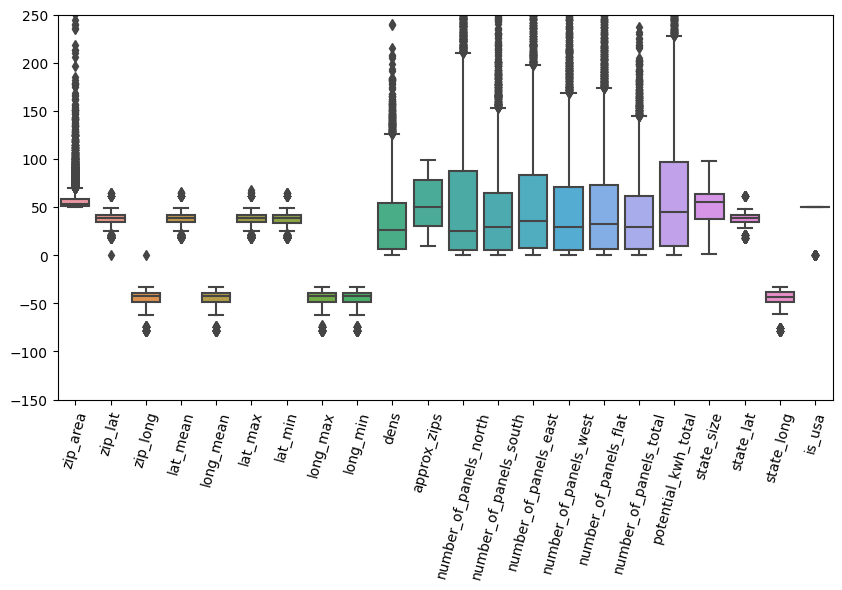

In [143]:
# We do scaling b/c linear model will be attempted to fit to data.
# Manual scaling is done here as a draft using all available data. 
# Normally scaling multipliers need to be determined based on training data only and then applied to test data. 

feats_to_scale = ['zip_area', 'zip_lat', 'zip_long', 'lat_mean', 'long_mean', 'lat_max', 'lat_min', 'long_max', 'long_min', 'dens', 'approx_zips',
                  'number_of_panels_north', 'number_of_panels_south', 'number_of_panels_east', 'number_of_panels_west', 'number_of_panels_flat', 
                  'number_of_panels_total', 'potential_kwh_total', 'state_size', 'state_lat', 'state_long', 'is_usa']

mults = {
    'dens': 1e-5,
    'zip_area': 5e2,
    'zip_long': .5,
    'long_mean': .5,
    'number_of_panels_north': 3e-3,
    'number_of_panels_south': 5e-4,
    'number_of_panels_east': 1e-3,
    'number_of_panels_west': 7e-4,
    'number_of_panels_flat': 3e-4,
    'number_of_panels_total': 1e-4,
    'potential_kwh_total': 5e-7,
    'long_min': .5,
    'long_max': .5,
    'state_long': .5,
    'state_size': 10,
    'is_usa': 50
}

def apply_mults(df: pd.DataFrame, mults: dict) -> pd.DataFrame:
    """Function applies multipliers from the passed dict to respective columns of the passed df"""
    local_df = df.copy()
    for k in mults:
        local_df.loc[:, k] = local_df[k] * mults[k]
    return local_df

scaled_df = apply_mults(init_df, mults)

plt.figure(figsize=[10, 5])
sns.boxplot(scaled_df[feats_to_scale])
plt.ylim(bottom=-150, top=250); plt.xticks(rotation=75);

<a name='5'></a>
# Saving output

In [144]:
# listing all the columns to be used at the modeling stage. 
# We droped State and Zip code here, because they have been replaced with several new ones.

out_cols = [
    'lat_max',
    'lat_min',
    'long_max',
    'long_min',
    'number_of_panels_north',
    'number_of_panels_south',
    'number_of_panels_east',
    'number_of_panels_west',
    'number_of_panels_flat',
    'number_of_panels_total',
    'lat_mean',
    'long_mean',
    'zip_area',
    'dens',
    'approx_zips',
    'is_usa',
    'zip_lat',
    'zip_long',
    'state_size',
    'state_lat',
    'state_long',
    'potential_kwh_total'
]

In [145]:
for col in list(scaled_df):
    print(col, scaled_df[col].isna().sum())

zip_code 0
state 0
lat_max 0
lat_min 0
long_max 0
long_min 0
number_of_panels_north 0
number_of_panels_south 0
number_of_panels_east 0
number_of_panels_west 0
number_of_panels_flat 0
number_of_panels_total 0
potential_kwh_total 0
lat_mean 0
long_mean 0
zip_area 0
dens 0
approx_zips 0
is_usa 0
zip_lat 0
zip_long 0
state_size 0
state_lat 0
state_long 0


In [146]:
scaled_df[out_cols].to_csv('datasets/modeling_df.csv', index=False)